# Trabajo Final - Tostadora "Campesino"

## Autor: Leonard David Vivas Dallos

## Objetivo
Predecir la calidad del café basados en el Puntaje de Taza.

## Indicaciones

1. Analizar los datos y definir las variables que se utilizarán de input. Tenga cuidado que no se filtre información al momento de elegirlas.
2. Definir el preprocesamiento que se debe hacer tanto para las X como para la Y.
3. Entrenar al menos dos modelos de regresión.
4. Utilizar un método de explicabilidad (LIME, SHAP, Feature Importance)
5. Reportar resultados.

El paso inicial es cargar los datos y realizar un análisis exploratorio para entender las variables disponibles y su relación con el Puntaje de Taza. Como sabemos, la información brindada para este análisis viene en un archivo de Excel, .xlsx, que contiene la información necesaria para el análisis. En primer lugar, cargaremos los datos, y los revisaremos para identificar las variables relevantes y como podemos relacionarlas con el Puntaje de Taza.

In [458]:
# Importamos las librerías necesarias para el análisis de datos y visualización
import pandas as pd                # Librería para manipulación y análisis de datos (estructuras tipo DataFrame)
import numpy as np                 # Librería para operaciones numéricas y matrices
import matplotlib.pyplot as plt    # Librería para generar gráficos estáticos
import seaborn as sns              # Librería basada en matplotlib para visualización estadística más atractiva
import plotly.express as px        # Librería para crear gráficos interactivos y visualizaciones avanzadas
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # Importamos LabelEncoder para codificar variables categóricas
from sklearn.model_selection import GroupKFold, cross_val_score # Importamos GroupKFold para dividir los datos en grupos y cross_val_score para evaluar el modelo
from sklearn.ensemble import RandomForestRegressor # Importamos RandomForestRegressor para crear un modelo de regresión basado en árboles aleatorios
from sklearn.linear_model import Ridge # Importamos Ridge para crear un modelo de regresión lineal con regularización L2
from sklearn.pipeline import Pipeline # Importamos Pipeline para encadenar transformaciones y modelos en un flujo de trabajo
from sklearn.linear_model import LinearRegression # Importamos LinearRegression para crear un modelo de regresión lineal simple
from sklearn.metrics import mean_squared_error, r2_score, make_scorer # Importamos métricas para evaluar el rendimiento del modelo
from xgboost import XGBRegressor # Importamos XGBRegressor para crear un modelo de regresión basado en XGBoost
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Importamos GridSearchCV y RandomizedSearchCV para la búsqueda de hiperparámetros
from scipy.stats import uniform, randint # Importamos uniform y randint para definir distribuciones de probabilidad en la búsqueda de hiperparámetros
import shap
from sklearn.model_selection import train_test_split


# Configuraciones adicionales para mejorar la interacción y visualización
plt.style.use('ggplot')            # Establece el estilo de los gráficos a 'ggplot' para una estética tipo R
%matplotlib inline
pd.set_option('display.max_columns', None)  # Evita el truncamiento de columnas en la visualización de datos

### Archivo "CC FT 17   Formato de Control de Calidad Café de Trillado (1).xlsx"

In [318]:
# Inicialmente, cargamos los datos desde el archivo Excel
data_control_calidad = pd.read_excel("CC FT 17   Formato de Control de Calidad Café de Trillado (1).xlsx", skiprows=7)
# Revisamos las primeras filas del DataFrame para entender su estructura
data_control_calidad.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,%,C/NC,#,C/NC.1,C/NC.2,Unnamed: 9,N°,C/NC.3,SI/NO,Unnamed: 13
0,19-07-22,01-190722,Madre Laura,765.00,10.9,C,14.0,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ
1,19-7-22,09-190722,Tabi Natural,204.00,10.2,C,14.0,C,C,"Frutas maduras, nibs de cacao, acidez brillant...",85,C,Si,LFQ
2,19-07-22,10-190722,Don Mario,165.00,10.7,C,14.0,C,C,"Panela, durazno, miel, acidez brillante citric...",84.5,C,Si,LFQ
3,27-07-22,07-19-07-22,Don Felix,0.45,10.5,C,14.0,C,C,"Moras maduras, chocolate negro, acidez media c...",84.5,C,Si,LFQ
4,31-10-22,01-291022,Madre Laura,105.00,10.7,C,14.0,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ


Dado un vistazo inicial a los datos, por la configuración del archivo de Excel, tenemos que saltar las primeras 7 filas para obtener el DataFrame correctamente, sin embargo, aún tendremos que asignar manualmente los nombres de las columnas, ya que el archivo no los contiene en la fila 8 (por problemas de formato de filas combinadas).

In [319]:
# Asignamos manualmente los nombres de las columnas
data_control_calidad.columns = [
    'Fecha', 'Lote', 'Denominación', 'Cantidad', '% Humedad', 'C/NC Humedad', 'Mallas', 'C/NC Mallas', 'Verificación Física Café',
    'Notas de Catación', 'Puntaje de Taza', 'C/NC Puntaje de Taza', 'Liberación de Lote(Si/No)', 'Responsable'
]
# Revisamos nuevamente las primeras filas del DataFrame con los nombres de columnas actualizados
data_control_calidad.head()

,Fecha,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Notas de Catación,Puntaje de Taza,C/NC Puntaje de Taza,Liberación de Lote(Si/No),Responsable
0,19-07-22,01-190722,Madre Laura,765.00,10.9,C,14.0,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ
1,19-7-22,09-190722,Tabi Natural,204.00,10.2,C,14.0,C,C,"Frutas maduras, nibs de cacao, acidez brillant...",85,C,Si,LFQ
2,19-07-22,10-190722,Don Mario,165.00,10.7,C,14.0,C,C,"Panela, durazno, miel, acidez brillante citric...",84.5,C,Si,LFQ
3,27-07-22,07-19-07-22,Don Felix,0.45,10.5,C,14.0,C,C,"Moras maduras, chocolate negro, acidez media c...",84.5,C,Si,LFQ
4,31-10-22,01-291022,Madre Laura,105.00,10.7,C,14.0,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ


In [320]:
data_control_calidad['Fecha'] = pd.to_datetime(data_control_calidad['Fecha'], dayfirst=True, errors='coerce')

data_control_calidad.head()

C:\Users\David\AppData\Local\Temp\ipykernel_18724\640125936.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_control_calidad['Fecha'] = pd.to_datetime(data_control_calidad['Fecha'], dayfirst=True, errors='coerce')


,Fecha,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Notas de Catación,Puntaje de Taza,C/NC Puntaje de Taza,Liberación de Lote(Si/No),Responsable
0,2022-07-19,01-190722,Madre Laura,765.00,10.9,C,14.0,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ
1,2022-07-19,09-190722,Tabi Natural,204.00,10.2,C,14.0,C,C,"Frutas maduras, nibs de cacao, acidez brillant...",85,C,Si,LFQ
2,2022-07-19,10-190722,Don Mario,165.00,10.7,C,14.0,C,C,"Panela, durazno, miel, acidez brillante citric...",84.5,C,Si,LFQ
3,2022-07-27,07-19-07-22,Don Felix,0.45,10.5,C,14.0,C,C,"Moras maduras, chocolate negro, acidez media c...",84.5,C,Si,LFQ
4,2022-10-31,01-291022,Madre Laura,105.00,10.7,C,14.0,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ


#### Archivo "CC FT 18  Formato de  Tostión (1).xlsx"

In [321]:
data_tostion = pd.read_excel("CC FT 18  Formato de  Tostión (1).xlsx", skiprows=5)

data_tostion.head()

,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste,Observaciones,Tostador
0,22-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,175°/191°,08:01:00,NaN,LFQ
1,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,175°/195°,08:42:00,NaN,LFQ
2,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,175°/190°,07:58:00,NaN,LFQ
3,28-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,175°/191°,08:02:00,NaN,LFQ
4,28-07-22,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,150°/186°,08:10:00,NaN,LFQ


Podemos ver que la columna de "Temp. De inicio y final" contiene dos valores separados por un /, lo que indica que debemos dividir esta columna en dos columnas separadas: "Temp. De inicio" y "Temp. Final". Esto nos permitirá trabajar con los datos de temperatura de manera más efectiva.

In [322]:
# Dividimos la columna "Temp. De inicio y final" en dos columnas separadas
data_tostion[['Temp. De inicio', 'Temp. Final']] = data_tostion['Temp. De inicio y final'].str.split('/', expand=True)
# Eliminamos la columna original "Temp. De inicio y final"
data_tostion.drop(columns=['Temp. De inicio y final'], inplace=True)
# Revisamos las primeras filas del DataFrame de tostión
data_tostion.head()

,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Tiempo de tueste,Observaciones,Tostador,Temp. De inicio,Temp. Final
0,22-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,08:01:00,NaN,LFQ,175°,191°
1,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,08:42:00,NaN,LFQ,175°,195°
2,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,07:58:00,NaN,LFQ,175°,190°
3,28-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,08:02:00,NaN,LFQ,175°,191°
4,28-07-22,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,08:10:00,NaN,LFQ,150°,186°


Adicionalmente, revisemos los nombres de las columnas del archivo de tostión para asegurarnos de que están correctamente asignados y no contienen espacios adicionales o caracteres no deseados.

In [323]:
print(data_tostion.columns.tolist())

['Fecha ', 'Lote ', 'Origen', 'Variedad', 'Proceso', 'Beneficio ', 'Peso en Verde', 'Merma ', 'Peso en Tostado ', 'Perfil ', 'Tiempo de tueste', 'Observaciones ', 'Tostador', 'Temp. De inicio', 'Temp. Final']


Como presentiamos, las columnas tienen espacios adicionales, lo que puede causar problemas al acceder a ellas. Por lo tanto, es importante eliminar estos espacios para evitar errores en el análisis posterior. Aparte de hacer esto, formatearemos las fechas para que todas tengan el mismo formato, lo que facilitará su manejo y análisis posterior.

In [324]:
data_tostion.columns = data_tostion.columns.str.strip()

data_tostion['Fecha'] = pd.to_datetime(data_tostion['Fecha'], dayfirst=True, errors='coerce')

data_tostion.head()

C:\Users\David\AppData\Local\Temp\ipykernel_18724\1680212727.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_tostion['Fecha'] = pd.to_datetime(data_tostion['Fecha'], dayfirst=True, errors='coerce')


,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Tiempo de tueste,Observaciones,Tostador,Temp. De inicio,Temp. Final
0,2022-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,08:01:00,NaN,LFQ,175°,191°
1,2022-07-25,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,08:42:00,NaN,LFQ,175°,195°
2,2022-07-25,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,07:58:00,NaN,LFQ,175°,190°
3,2022-07-28,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,08:02:00,NaN,LFQ,175°,191°
4,2022-07-28,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,08:10:00,NaN,LFQ,150°,186°


Observemos que la columna "Observaciones" al parecer solo contiene NaN, lo que indica que no hay información en esta. Confirmemos esto y, si es así, eliminaremos esta columna del DataFrame para evitar confusiones en el análisis posterior.

In [325]:
# Revisar valores de "Observaciones" para confirmar si contiene solo NaN
observaciones_nulos = data_tostion['Observaciones'].isnull().all()
if observaciones_nulos:
    # Si la columna "Observaciones" contiene solo NaN, la eliminamos
    data_tostion.drop(columns=['Observaciones'], inplace=True)
else:
    print("La columna 'Observaciones' contiene datos y no se eliminará.")

In [326]:
data_tostion.head()

,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Tiempo de tueste,Tostador,Temp. De inicio,Temp. Final
0,2022-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,08:01:00,LFQ,175°,191°
1,2022-07-25,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,08:42:00,LFQ,175°,195°
2,2022-07-25,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,07:58:00,LFQ,175°,190°
3,2022-07-28,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,08:02:00,LFQ,175°,191°
4,2022-07-28,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,08:10:00,LFQ,150°,186°


#### Archivo "CC FT 21   Formato de Control de Despachos (1).xlsx"

In [327]:
data_despachos = pd.read_excel("CC FT 21   Formato de Control de Despachos (1).xlsx", skiprows=5)

# Eliminamos la primera fila que contiene el encabezado duplicado
data_despachos = data_despachos.iloc[1:]

data_despachos.head()

,# PEDIDO,FECHA DE TUESTE,FECHA DE EMPAQUE,TIPO DE CAFÉ,PRESENTACIÓN,Unnamed: 5,CANTIDAD,Unnamed: 7,Unnamed: 8,CLIENTE,RESPONSABLE DESPACHO,VERIFICA
1,564,22-7-22,25-7-22,Madre Laura,500 Gr,NaN,3.0,NaN,NaN,Natalia Londoño,LFQ,MS
2,564,22-7-22,25-7-22,Madre Laura,1000 Gr,NaN,1.0,NaN,NaN,Natalia Londoño,LFQ,MS
3,566,22-7-22,25-7-22,Madre Laura,2500 Gr,NaN,2.0,NaN,NaN,Mateo Duque,LFQ,MS
4,567,22-7-22,26-7-22,Madre Laura,2500 Gr,NaN,1.0,NaN,NaN,Akio,LFQ,MS
5,568,25-7-22,26-7-22,Madre Laura,2500 Gr,NaN,3.0,NaN,NaN,Juan Camilo Baez,LFQ,MS


En un primer vistazo, podemos ver que tenemos ciertas columnas que no traen información alguna, esto debido al manejo de las columnas combinadas en el archivo de Excel. Por lo tanto, debemos eliminar las columnas que no contienen información relevante para nuestro análisis.

In [328]:
# Eliminamos las columnas con nombre Unnamed que no contienen información relevante
data_despachos = data_despachos.loc[:, ~data_despachos.columns.str.contains('^Unnamed')]
# Revisamos las primeras filas del DataFrame de despachos
data_despachos.head()

,# PEDIDO,FECHA DE TUESTE,FECHA DE EMPAQUE,TIPO DE CAFÉ,PRESENTACIÓN,CANTIDAD,CLIENTE,RESPONSABLE DESPACHO,VERIFICA
1,564,22-7-22,25-7-22,Madre Laura,500 Gr,3.0,Natalia Londoño,LFQ,MS
2,564,22-7-22,25-7-22,Madre Laura,1000 Gr,1.0,Natalia Londoño,LFQ,MS
3,566,22-7-22,25-7-22,Madre Laura,2500 Gr,2.0,Mateo Duque,LFQ,MS
4,567,22-7-22,26-7-22,Madre Laura,2500 Gr,1.0,Akio,LFQ,MS
5,568,25-7-22,26-7-22,Madre Laura,2500 Gr,3.0,Juan Camilo Baez,LFQ,MS


Revisemos si en este caso tenemos el mismo comportamiento de columnas que en el archivo de tostión, es decir, si las columnas tienen espacios adicionales o caracteres no deseados. Si es así, debemos limpiarlas para evitar problemas al acceder a ellas. Además, debemos asegurarnos de que las fechas estén en un formato consistente para facilitar su manejo y análisis posterior.

In [329]:
print(data_despachos.columns.tolist())

['# PEDIDO ', 'FECHA DE TUESTE ', 'FECHA DE EMPAQUE ', 'TIPO DE CAFÉ   ', 'PRESENTACIÓN ', 'CANTIDAD ', 'CLIENTE ', 'RESPONSABLE DESPACHO ', 'VERIFICA ']


In [330]:
data_despachos.columns = data_despachos.columns.str.strip()

data_despachos['FECHA DE TUESTE'] = pd.to_datetime(data_despachos['FECHA DE TUESTE'], dayfirst=True, errors='coerce')
data_despachos['FECHA DE EMPAQUE'] = pd.to_datetime(data_despachos['FECHA DE EMPAQUE'], dayfirst=True, errors='coerce')

data_despachos.head()

C:\Users\David\AppData\Local\Temp\ipykernel_18724\376962012.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_despachos['FECHA DE TUESTE'] = pd.to_datetime(data_despachos['FECHA DE TUESTE'], dayfirst=True, errors='coerce')
C:\Users\David\AppData\Local\Temp\ipykernel_18724\376962012.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_despachos['FECHA DE EMPAQUE'] = pd.to_datetime(data_despachos['FECHA DE EMPAQUE'], dayfirst=True, errors='coerce')


,# PEDIDO,FECHA DE TUESTE,FECHA DE EMPAQUE,TIPO DE CAFÉ,PRESENTACIÓN,CANTIDAD,CLIENTE,RESPONSABLE DESPACHO,VERIFICA
1,564,2022-07-22,2022-07-25,Madre Laura,500 Gr,3.0,Natalia Londoño,LFQ,MS
2,564,2022-07-22,2022-07-25,Madre Laura,1000 Gr,1.0,Natalia Londoño,LFQ,MS
3,566,2022-07-22,2022-07-25,Madre Laura,2500 Gr,2.0,Mateo Duque,LFQ,MS
4,567,2022-07-22,2022-07-26,Madre Laura,2500 Gr,1.0,Akio,LFQ,MS
5,568,2022-07-25,2022-07-26,Madre Laura,2500 Gr,3.0,Juan Camilo Baez,LFQ,MS


### Análisis de los archivos

Ya obtenidos los DataFrames de los archivos de Excel, y limpiados los nombres de las columnas y los tipos de algunas columnas, procedemos a realizar un análisis exploratorio de los datos, entre estos, revisaremos a que hace referencia cada columna, si tiene información relevante, si es necesario eliminarla o transformarla, y si es necesario realizar algún tipo de preprocesamiento adicional. Adicionalmente, revisaremos cual de esta información es posible usar para nuestro objetivo de predecir el Puntaje de Taza, para así evitar filtrar información al momento de elegir las variables de entrada (X) y la variable objetivo (Y).

Comencemos revisando cada uno de los archivos, y expliquemos que información contiene cada uno de ellos, y como podemos relacionarlos entre sí para obtener la información necesaria para nuestro análisis.

**Archivo "CC FT 17   Formato de Control de Calidad Café de Trillado (1).xlsx"**

| Columna                              | Descripción                                                                                            |
| ------------------------------------ | ------------------------------------------------------------------------------------------------------ |
| **Fecha**                            | Fecha en que se realiza el control de calidad del lote.                                                |
| **Lote**                             | Identificador único del lote evaluado. Permite la trazabilidad con los otros formatos.                 |
| **Denominación**                     | Nombre comercial o tipo de café dentro del lote.                                                       |
| **Cantidad**                         | Cantidad total de café evaluado (probablemente en kg).                                                 |
| **%H**                               | Porcentaje de humedad del café. Se evalúa si cumple (C) o no cumple (NC) con los estándares.           |
| **Mallas**                           | Tamaño de grano evaluado con tamices (mallas). Se indica el número de malla y si cumple (C) o no (NC). |
| **Verificación Física Café Tostado** | Inspección física del grano tostado, indicando si cumple con las características deseadas (N/NC).      |
| **Notas de Catación**                | Comentarios cualitativos del catador sobre aroma, sabor, acidez, cuerpo, etc.                          |
| **Puntaje**                          | Evaluación cuantitativa del café en taza (SCA score). Se indica el número y si cumple (C/NC).          |
| **Liberación de lote**               | Indica si el lote fue aprobado para comercialización (Sí / No).                                        |
| **Responsable**                      | Nombre de la persona que realizó la evaluación.                                                        |



**Archivo "CC FT 18  Formato de  Tostión (1).xlsx"**

| Columna              | Descripción                                                                              |
| -------------------- | ---------------------------------------------------------------------------------------- |
| **Fecha**            | Fecha en que se realizó la tostión del lote.                                             |
| **Lote**             | Identificador del lote, que debería coincidir con el de calidad.                         |
| **Origen**           | Lugar o finca de donde proviene el café verde. Influye en las propiedades sensoriales.   |
| **Variedad**         | Tipo de grano (Ej: Caturra, Castillo, Geisha, etc). Importante para el perfil sensorial. |
| **Proceso**          | Proceso postcosecha (lavado, natural, honey, etc). Afecta sabor, acidez, cuerpo.         |
| **Beneficio**        | Método de beneficio húmedo o seco (posiblemente nombre de la estación de beneficio).     |
| **Peso en Verde**    | Peso del café antes de tostar.                                                           |
| **Merma**            | Pérdida de peso durante el tostado (por evaporación). Importante para rendimiento.       |
| **Peso en Tostado**  | Peso final del lote después del proceso de tostión.                                      |
| **Perfil**           | Perfil de tostión buscado (claro, medio, oscuro). Determina la expresión de sabores.     |
| **Temp. de Inicio**  | Temperatura inicial del tambor o tostadora al empezar.                                   |
| **Temp. de Final**   | Temperatura al final del proceso de tostión.                                             |
| **Tiempo de Tueste** | Duración total del proceso de tostión (en minutos).                                      |
| **Tostador**         | Nombre del operario o responsable de la tostión.                                         |


**Archivo "CC FT 21   Formato de Control de Despachos (1).xlsx"**

| Columna                  | Descripción                                                                    |
| ------------------------ | ------------------------------------------------------------------------------ |
| **# Pedido**             | Número de pedido asignado para el despacho del café.                           |
| **Fecha de Tueste**      | Fecha en la que se realizó el tostado del café despachado. Útil para frescura. |
| **Fecha de Empaque**     | Fecha en la que se empacó el producto final. También influye en la frescura.   |
| **Tipo de Café**         | Clasificación del café (especial, premium, estándar, etc.).                    |
| **Presentación**         | Formato de entrega (molido, en grano, en bolsa de 250g, etc.).                 |
| **Cantidad**             | Cantidad de café despachado.                                                   |
| **Cliente**              | Nombre del cliente o entidad a la que se realizó el despacho.                  |
| **Responsable Despacho** | Nombre del encargado del despacho.                                             |
| **Quién verifica**       | Persona que valida el despacho antes de salir.                                 |


Una vez tenemos la información de las columnas, es importante detectar cuales son las variables que son útiles para determinar el Puntaje de Taza, pero más importante aún, es detectar si tenemos información que no tenemos disponible al momento de hacer la predicción, ya que esto nos permitirá definir las variables de entrada (X) y la variable objetivo (Y) de nuestro modelo de regresión. Para esto, según el análisis de las columnas en el contexto en que estamos, podemos definir las siguientes variables:

**Archivo "CC FT 17   Formato de Control de Calidad Café de Trillado (1).xlsx"**

En cuanto a este archivo, se puede notar que tenemos la variable a predecir, el Puntaje de Taza, que se encuentra en la columna "Puntaje". Por otro lado, notemos que tenemos algunas columnas que no tenemos a la mano al momento del análisis

In [331]:
data_control_calidad.head()

,Fecha,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Notas de Catación,Puntaje de Taza,C/NC Puntaje de Taza,Liberación de Lote(Si/No),Responsable
0,2022-07-19,01-190722,Madre Laura,765.00,10.9,C,14.0,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ
1,2022-07-19,09-190722,Tabi Natural,204.00,10.2,C,14.0,C,C,"Frutas maduras, nibs de cacao, acidez brillant...",85,C,Si,LFQ
2,2022-07-19,10-190722,Don Mario,165.00,10.7,C,14.0,C,C,"Panela, durazno, miel, acidez brillante citric...",84.5,C,Si,LFQ
3,2022-07-27,07-19-07-22,Don Felix,0.45,10.5,C,14.0,C,C,"Moras maduras, chocolate negro, acidez media c...",84.5,C,Si,LFQ
4,2022-10-31,01-291022,Madre Laura,105.00,10.7,C,14.0,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ


In [332]:
# Impresión de distintos responsables
responsables = data_control_calidad['Responsable'].unique()
print("Responsables únicos en el archivo de control de calidad:")
for responsable in responsables:
    print(responsable)

print(responsables)


Responsables únicos en el archivo de control de calidad:
LFQ
LFQ 
nan
['LFQ' 'LFQ ' nan]


Para este archivo, notemos que solo tenemos un responsable, lo que indica que no es información que aporte mucho de momento al análisis. Sin embargo, revisarlo nos permite identificar un problema que debemos tener en cuenta y es que es posible que mismos valores esten difiriendo en nuestro análisis debido a errores de tipeo o introducción de espacios en el mapeo. Sin embargo, analizaremos esto más adelante, cuando tengamos los datos consolidados.

Las notas de catación son una columna que contiene información cualitativa, que es bastante difícil de manejar, por lo que la descartaremos de momento. Por otro lado, la columna "C/NC Puntaje de Taza" y "Liberación de lote" son columnas que están derivadas de nuestra variable objetivo, por lo que no las utilizaremos como variables de entrada. Finalmente, la columna "Responsable" es una columna que no aporta información relevante para nuestro análisis, ya que solo tenemos un responsable, por lo que la descartaremos de momento.

In [333]:
# Eliminamos las columnas que no aportan información relevante
data_control_calidad = data_control_calidad.drop(columns=['Responsable', 'Notas de Catación', 'C/NC Puntaje de Taza', 'Liberación de Lote(Si/No)'])
# Revisamos las primeras filas del DataFrame de control de calidad
data_control_calidad.head()

,Fecha,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Puntaje de Taza
0,2022-07-19,01-190722,Madre Laura,765.00,10.9,C,14.0,C,C,84
1,2022-07-19,09-190722,Tabi Natural,204.00,10.2,C,14.0,C,C,85
2,2022-07-19,10-190722,Don Mario,165.00,10.7,C,14.0,C,C,84.5
3,2022-07-27,07-19-07-22,Don Felix,0.45,10.5,C,14.0,C,C,84.5
4,2022-10-31,01-291022,Madre Laura,105.00,10.7,C,14.0,C,C,84


**Archivo "CC FT 18  Formato de  Tostión (1).xlsx"**

Para este archivo, notemos que tenemos la información general del proceso de tostión para el lote, lo que nos permitirá relacionar este proceso con el Puntaje de Taza. Sin embargo, revisemos cuantos tostadores tenemos, ya que si tenemos más de uno, debemos tener en cuenta que cada uno puede tener un perfil de tostión diferente, lo que puede afectar el Puntaje de Taza. Por lo tanto, debemos revisar si tenemos información suficiente para relacionar el Puntaje de Taza con el proceso de tostión.

In [334]:
# Verificamos si tenemos más de un tostador
tostadores = data_tostion['Tostador'].unique()
if len(tostadores) > 1:
    print(f"Tenemos {len(tostadores)} tostadores diferentes: {', '.join(tostadores)}")
    

Tenemos 2 tostadores diferentes: LFQ, LFQ 


Nuevamente, tenemos el mismo fenómeno de espacios en los nombres de las columnas, sin embargo, solo tenemos un tostador, por lo que lo podemos omitir de momento, el resto de columnas son relevantes para nuestro análisis, ya que nos permiten relacionar el proceso de tostión con el Puntaje de Taza. Por lo tanto, las utilizaremos como variables de entrada.

In [335]:
# Eliminamos las columnas que no aportan información relevante
data_tostion = data_tostion.drop(columns=['Tostador'])
# Revisamos las primeras filas del DataFrame de tostión
data_tostion.head()

,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Tiempo de tueste,Temp. De inicio,Temp. Final
0,2022-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,08:01:00,175°,191°
1,2022-07-25,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,08:42:00,175°,195°
2,2022-07-25,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,07:58:00,175°,190°
3,2022-07-28,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,08:02:00,175°,191°
4,2022-07-28,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,08:10:00,150°,186°


**Archivo "CC FT 21   Formato de Control de Despachos (1).xlsx"**

En general, este archivo, como su nombre lo indica, contiene información sobre el despacho del café, por lo que no es relevante para nuestro análisis, ya que no tenemos información sobre el Puntaje de Taza. Por lo que directamente no lo utilizaremos en nuestro análisis.

En este punto, necesitamos consolidar la información de los archivos de Control de Calidad y Tostión, para así tener un DataFrame que contenga toda la información relevante para nuestro análisis. Sin embargo, es importante notar ciertos puntos.

- Inconsistencia de las fechas: Las fechas en ambos archivos difieren para un mismo lote y es que, para un mismo lote, la fecha de tostión puede ser diferente a la fecha de control de calidad (en algunas ocasiones, los controles de calidad se realizan después de la tostión, pero sobre un pequeño fragmento ya tostado del lote). Por lo tanto, debemos tener en cuenta que las fechas pueden no coincidir y que debemos relacionar los datos por el lote y no por la fecha. Es por esto que las fechas las vamos a ignorar de momento.

- Agrupación por lotes y suposición de resultados uniformes: Al consolidar los datos, debemos tener en cuenta que los lotes tienen múltiples registros de tostión, a pesar de que solo tienen un Puntaje de Taza. En un análisis inicial, se trató de hacer un mapeo buscando cual de los procesos de tostión era el que se había utilizado para el Puntaje de Taza, sin embargo, no fue posible pues incluso hay algunas catas que tienen tosteos posteriores. Por lo tanto, vamos a asumir que el Puntaje de Taza es el mismo para todos los registros de tostión del mismo lote, sin importar el perfil de tostión utilizado. Esto implica que vamos a consolidar los datos por lote, y vamos a tomar el Puntaje de Taza como el mismo para todos los registros de tostión del mismo lote.

Siendo así, solo resta consolidar los datos de los archivos de Control de Calidad y Tostión, para así tener un DataFrame que contenga toda la información relevante para nuestro análisis. Para esto, vamos a hacer un merge entre los dos DataFrames, utilizando la columna "Lote" como clave de unión. Esto nos permitirá tener un DataFrame que contenga toda la información relevante para nuestro análisis, y que podamos utilizar para entrenar nuestros modelos de regresión.

In [336]:
# Consolidación de los datos de Control de Calidad y Tostión
# Realizamos un merge entre los dos DataFrames, utilizando la columna "Lote" como clave de unión
data_consolidado = pd.merge(data_control_calidad, data_tostion, on='Lote', how='inner')

# Revisamos las primeras filas del DataFrame consolidado
data_consolidado.head()

,Fecha_x,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Puntaje de Taza,Fecha_y,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Tiempo de tueste,Temp. De inicio,Temp. Final
0,2022-07-19,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,2022-07-22,Jerico,Dos mil,Tradicional,Lavado,9.0,15.000000,7.65,Filtrado,08:01:00,175°,191°
1,2022-07-19,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,2022-07-25,Jerico,Dos mil,Tradicional,Lavado,3.0,16.666667,2.50,Espressso,08:42:00,175°,195°
2,2022-07-19,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,2022-07-25,Jerico,Dos mil,Tradicional,Lavado,9.0,16.444444,7.52,Filtrado,07:58:00,175°,190°
3,2022-07-19,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,2022-07-28,Jerico,Dos mil,Tradicional,Lavado,11.7,16.324786,9.79,Filtrado,08:02:00,175°,191°
4,2022-07-19,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,2022-07-31,Jerico,Dos mil,Tradicional,Lavado,29.0,15.344828,24.55,Filtrado,08:02:00,175°,192°


In [337]:
# Eliminamos las columnas de fechas que no aportan información relevante
data_consolidado = data_consolidado.drop(columns=['Fecha_x', 'Fecha_y'])

# Revisamos las primeras filas del DataFrame consolidado después de eliminar las columnas de fechas
data_consolidado.head()

,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Puntaje de Taza,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Tiempo de tueste,Temp. De inicio,Temp. Final
0,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,9.0,15.000000,7.65,Filtrado,08:01:00,175°,191°
1,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,3.0,16.666667,2.50,Espressso,08:42:00,175°,195°
2,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,9.0,16.444444,7.52,Filtrado,07:58:00,175°,190°
3,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,11.7,16.324786,9.79,Filtrado,08:02:00,175°,191°
4,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,29.0,15.344828,24.55,Filtrado,08:02:00,175°,192°


Debemos tener en cuenta que al hacer el merge, algunas filas pueden no tener información en algunas columnas, ya que no todos los lotes tienen registros de tostión, o no todos los lotes tienen registros de control de calidad. Por lo tanto, debemos tener en cuenta que algunas columnas pueden tener valores NaN, y debemos manejarlos adecuadamente para evitar problemas en el análisis posterior.

## Preprocesamiento de los datos

El proceso inicial de preprocesamiento de los datos va a consistir en modificar las columnas categoricas para que sean numéricas. Para esto, recordemos que debemos tener en cuenta el problema de los espacios en los nombres de las filas.

In [338]:
# Revisemos los tipos de datos de las columnas del DataFrame consolidado
data_consolidado.dtypes

Lote                         object
Denominación                 object
Cantidad                    float64
% Humedad                   float64
C/NC Humedad                 object
Mallas                      float64
C/NC Mallas                  object
Verificación Física Café     object
Puntaje de Taza              object
Origen                       object
Variedad                     object
Proceso                      object
Beneficio                    object
Peso en Verde               float64
Merma                       float64
Peso en Tostado             float64
Perfil                       object
Tiempo de tueste             object
Temp. De inicio              object
Temp. Final                  object
dtype: object

In [339]:
# Aplicar strip() solo a columnas tipo objeto (texto)
for col in data_consolidado.select_dtypes(include=['object']).columns:
    data_consolidado[col] = data_consolidado[col].astype(str).str.strip()


In [340]:
data_consolidado.head()

,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Puntaje de Taza,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Tiempo de tueste,Temp. De inicio,Temp. Final
0,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,9.0,15.000000,7.65,Filtrado,08:01:00,175°,191°
1,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,3.0,16.666667,2.50,Espressso,08:42:00,175°,195°
2,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,9.0,16.444444,7.52,Filtrado,07:58:00,175°,190°
3,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,11.7,16.324786,9.79,Filtrado,08:02:00,175°,191°
4,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,29.0,15.344828,24.55,Filtrado,08:02:00,175°,192°


En primer lugar, pasemos la columna de tiempo de tueste a una cantidad de tiempo, en minutos

In [341]:
data_consolidado['Tiempo de tueste'] = pd.to_timedelta(data_consolidado['Tiempo de tueste'])
data_consolidado['Tiempo de tueste (min)'] = data_consolidado['Tiempo de tueste'].dt.total_seconds() / 60
data_consolidado = data_consolidado.drop(columns='Tiempo de tueste')

data_consolidado.head()

,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Puntaje de Taza,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio,Temp. Final,Tiempo de tueste (min)
0,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,9.0,15.000000,7.65,Filtrado,175°,191°,481.0
1,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,3.0,16.666667,2.50,Espressso,175°,195°,522.0
2,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,9.0,16.444444,7.52,Filtrado,175°,190°,478.0
3,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,11.7,16.324786,9.79,Filtrado,175°,191°,482.0
4,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,29.0,15.344828,24.55,Filtrado,175°,192°,482.0


Además, debemos convertir los datos de las temperaturas de inicio y final a valores numéricos, ya que actualmente están en formato de texto. Esto nos permitirá trabajar con ellos de manera más efectiva en nuestro modelo de regresión.

In [342]:
# Impresión de distintas temperaturas de inicio y final
temperaturas_inicio = data_consolidado['Temp. De inicio'].unique()
temperaturas_final = data_consolidado['Temp. Final'].unique()
print("Temperaturas de inicio únicas:")
print(temperaturas_inicio)
print("Temperaturas finales únicas:")
print(temperaturas_final)

Temperaturas de inicio únicas:
['175°' '175°192°' '150°' '170°' '180°']
Temperaturas finales únicas:
['191°' '195°' '190°' '192°' '196°' '193°' '192' '195' '196' '194°' 'None'
 '186°' '189°']


Aquí encontramos un problema en un dato específico que no tenía la división /, por lo que debemos corregirlo manualmente. Esto es importante para evitar errores en el análisis posterior.

In [343]:
# Obtenemos el dato específico que no tenía la división /
data_consolidado['Temp. De inicio'] = data_consolidado['Temp. De inicio'].replace('175°192°', '175°')
data_consolidado['Temp. Final'] = data_consolidado['Temp. Final'].replace('None', '192°')

In [344]:
# Eliminar el símbolo "°C" y convertir a float
data_consolidado['Temp. De inicio'] = data_consolidado['Temp. De inicio'].str.replace('°', '').astype(float)
data_consolidado['Temp. Final'] = data_consolidado['Temp. Final'].str.replace('°', '').astype(float)

# Convertir las columnas de temperatura a tipo float
data_consolidado.head()

,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Puntaje de Taza,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio,Temp. Final,Tiempo de tueste (min)
0,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,9.0,15.000000,7.65,Filtrado,175.0,191.0,481.0
1,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,3.0,16.666667,2.50,Espressso,175.0,195.0,522.0
2,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,9.0,16.444444,7.52,Filtrado,175.0,190.0,478.0
3,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,11.7,16.324786,9.79,Filtrado,175.0,191.0,482.0
4,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84,Jerico,Dos mil,Tradicional,Lavado,29.0,15.344828,24.55,Filtrado,175.0,192.0,482.0


Ahora si, codifiquemos las columnas categóricas para que sean numéricas, y así poder utilizarlas en nuestro modelo de regresión. Para esto, vamos a utilizar la función `labelencoder()` de sklearn, que nos permite convertir las columnas categóricas en variables numéricas que podemos utilizar en nuestro modelo de regresión.

In [345]:
# Tipos de las columnas
print(data_consolidado.dtypes)

Lote                         object
Denominación                 object
Cantidad                    float64
% Humedad                   float64
C/NC Humedad                 object
Mallas                      float64
C/NC Mallas                  object
Verificación Física Café     object
Puntaje de Taza              object
Origen                       object
Variedad                     object
Proceso                      object
Beneficio                    object
Peso en Verde               float64
Merma                       float64
Peso en Tostado             float64
Perfil                       object
Temp. De inicio             float64
Temp. Final                 float64
Tiempo de tueste (min)      float64
dtype: object


Como vemos, debemos convertir la columna de "Puntaje de Taza" a una variable numérica, ya que actualmente está en formato de texto.

In [346]:
# Convertir la columna "Puntaje de Taza" a numérico
data_consolidado['Puntaje de Taza'] = pd.to_numeric(data_consolidado['Puntaje de Taza'], errors='coerce')

data_consolidado.head()

,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Puntaje de Taza,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio,Temp. Final,Tiempo de tueste (min)
0,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84.0,Jerico,Dos mil,Tradicional,Lavado,9.0,15.000000,7.65,Filtrado,175.0,191.0,481.0
1,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84.0,Jerico,Dos mil,Tradicional,Lavado,3.0,16.666667,2.50,Espressso,175.0,195.0,522.0
2,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84.0,Jerico,Dos mil,Tradicional,Lavado,9.0,16.444444,7.52,Filtrado,175.0,190.0,478.0
3,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84.0,Jerico,Dos mil,Tradicional,Lavado,11.7,16.324786,9.79,Filtrado,175.0,191.0,482.0
4,01-190722,Madre Laura,765.0,10.9,C,14.0,C,C,84.0,Jerico,Dos mil,Tradicional,Lavado,29.0,15.344828,24.55,Filtrado,175.0,192.0,482.0


In [347]:
# Crear un LabelEncoder
le = LabelEncoder()

# Aplicar a todas las columnas categóricas
for col in data_consolidado.select_dtypes(include=['object']).columns:
    data_consolidado[col] = le.fit_transform(data_consolidado[col])

In [348]:
data_consolidado.head()

,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Puntaje de Taza,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio,Temp. Final,Tiempo de tueste (min)
0,4,12,765.0,10.9,0,14.0,0,0,84.0,4,3,3,2,9.0,15.000000,7.65,2,175.0,191.0,481.0
1,4,12,765.0,10.9,0,14.0,0,0,84.0,4,3,3,2,3.0,16.666667,2.50,1,175.0,195.0,522.0
2,4,12,765.0,10.9,0,14.0,0,0,84.0,4,3,3,2,9.0,16.444444,7.52,2,175.0,190.0,478.0
3,4,12,765.0,10.9,0,14.0,0,0,84.0,4,3,3,2,11.7,16.324786,9.79,2,175.0,191.0,482.0
4,4,12,765.0,10.9,0,14.0,0,0,84.0,4,3,3,2,29.0,15.344828,24.55,2,175.0,192.0,482.0


Como podemos ver, ya tenemos variables numéricas que podemos utilizar en nuestros modelos de regresión. Sin embargo, convendrá normalizar algunas de estas variables, ya que algunas tienen un rango de valores mucho mayor que otras, lo que puede afectar el rendimiento del modelo. Por ejemplo, las temperaturas de inicio y final tienen un rango de valores mucho mayor que las demás variables, por lo que convendrá normalizarlas para evitar problemas de escala.

In [349]:
# Lista de columnas numéricas para normalizar
columnas_a_normalizar = ['Cantidad', 'Peso en Verde', 'Merma', 'Peso en Tostado', 'Temp. De inicio', 'Temp. Final', 'Tiempo de tueste (min)', '% Humedad']

# Generar un objeto MinMaxScaler
scaler = MinMaxScaler()
# Normalizar las columnas seleccionadas
data_consolidado[columnas_a_normalizar] = scaler.fit_transform(data_consolidado[columnas_a_normalizar])

# Mostramos las primeras filas del DataFrame consolidado después de la normalización
data_consolidado.head()

,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Puntaje de Taza,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio,Temp. Final,Tiempo de tueste (min)
0,4,12,1.0,0.7,0,14.0,0,0,84.0,4,3,3,2,0.042846,0.210165,0.043731,2,0.833333,0.5,0.702586
1,4,12,1.0,0.7,0,14.0,0,0,84.0,4,3,3,2,0.012779,0.313187,0.012922,1,0.833333,0.9,0.879310
2,4,12,1.0,0.7,0,14.0,0,0,84.0,4,3,3,2,0.042846,0.299451,0.042953,2,0.833333,0.4,0.689655
3,4,12,1.0,0.7,0,14.0,0,0,84.0,4,3,3,2,0.056377,0.292054,0.056533,2,0.833333,0.5,0.706897
4,4,12,1.0,0.7,0,14.0,0,0,84.0,4,3,3,2,0.143072,0.231480,0.144831,2,0.833333,0.6,0.706897


Finalmente, eliminemos las filas que contengan valores NaN, estos valores nulos podrían venir por falta de información, o por el hecho de que en el merge de los datos, hay algunos lotes para los que no hay registros de tostión, o por otro lado, hay algunos lotes tostados sin control de calidad, esto se hace ya que no podemos utilizar estas filas en nuestro modelo de regresión. Esto es importante para evitar errores en el análisis posterior.

In [350]:
# Eliminamos las filas con valores NaN
data_consolidado.isnull().sum()

Lote                         0
Denominación                 0
Cantidad                     0
% Humedad                    0
C/NC Humedad                 0
Mallas                       0
C/NC Mallas                  0
Verificación Física Café     0
Puntaje de Taza             12
Origen                       0
Variedad                     0
Proceso                      0
Beneficio                    0
Peso en Verde                0
Merma                        0
Peso en Tostado              0
Perfil                       0
Temp. De inicio              0
Temp. Final                  0
Tiempo de tueste (min)       0
dtype: int64

In [351]:
# Ver los registros con puntaje de taza NaN
data_consolidado[data_consolidado['Puntaje de Taza'].isnull()]

,Lote,Denominación,Cantidad,% Humedad,C/NC Humedad,Mallas,C/NC Mallas,Verificación Física Café,Puntaje de Taza,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio,Temp. Final,Tiempo de tueste (min)
285,33,10,0.035667,0.1,0,14.0,0,0,NaN,4,4,2,3,0.027813,0.313187,0.027877,0,0.666667,0.5,0.797414
286,33,10,0.035667,0.1,0,14.0,0,0,NaN,4,4,2,3,0.027813,0.313187,0.027877,0,0.666667,0.5,0.797414
287,33,10,0.035667,0.1,0,14.0,0,0,NaN,4,4,2,3,0.042846,0.313187,0.042833,0,0.666667,0.5,0.797414
288,33,10,0.035667,0.1,0,14.0,0,0,NaN,4,4,2,3,0.027813,0.313187,0.027877,0,0.666667,0.5,0.797414
289,33,10,0.035667,0.1,0,14.0,0,0,NaN,4,4,2,3,0.037835,0.441964,0.036851,0,0.666667,0.5,0.797414
290,32,4,0.030383,0.3,0,14.0,0,0,NaN,4,3,1,2,0.057880,0.313187,0.057789,2,0.666667,0.3,0.806034
291,32,4,0.030383,0.3,0,14.0,0,0,NaN,4,3,1,2,0.003758,0.313187,0.003948,2,0.666667,0.3,0.806034
292,32,4,0.030383,0.3,0,14.0,0,0,NaN,4,3,1,2,0.012278,0.348712,0.012324,2,0.833333,0.6,0.750000
293,32,4,0.030383,0.3,0,14.0,0,0,NaN,4,3,1,2,0.003758,0.313187,0.003948,2,0.666667,0.5,0.452586
294,32,4,0.030383,0.3,0,14.0,0,0,NaN,4,3,1,2,0.027813,0.313187,0.027877,2,0.666667,0.5,0.711207


In [352]:
# Eliminamos las filas con valores NaN
data_consolidado = data_consolidado.dropna()# Revisamos las primeras filas del DataFrame consolidado después de eliminar las filas con valores Na

In [353]:
# Eliminamos las filas con valores NaN
data_consolidado.isnull().sum()

Lote                        0
Denominación                0
Cantidad                    0
% Humedad                   0
C/NC Humedad                0
Mallas                      0
C/NC Mallas                 0
Verificación Física Café    0
Puntaje de Taza             0
Origen                      0
Variedad                    0
Proceso                     0
Beneficio                   0
Peso en Verde               0
Merma                       0
Peso en Tostado             0
Perfil                      0
Temp. De inicio             0
Temp. Final                 0
Tiempo de tueste (min)      0
dtype: int64

Este DataFrame consolidado contiene toda la información relevante para nuestro análisis, y ya hemos realizado el preprocesamiento inicial de los datos. Ahora, veamos un poco cuál es la correlación entre las variables, para así poder identificar cuales son las variables que más influyen en el Puntaje de Taza, y así poder definir las variables de entrada (X) y la variable objetivo (Y) de nuestro modelo de regresión.

In [354]:
data_consolidado.dtypes

Lote                          int64
Denominación                  int64
Cantidad                    float64
% Humedad                   float64
C/NC Humedad                  int64
Mallas                      float64
C/NC Mallas                   int64
Verificación Física Café      int64
Puntaje de Taza             float64
Origen                        int64
Variedad                      int64
Proceso                       int64
Beneficio                     int64
Peso en Verde               float64
Merma                       float64
Peso en Tostado             float64
Perfil                        int64
Temp. De inicio             float64
Temp. Final                 float64
Tiempo de tueste (min)      float64
dtype: object

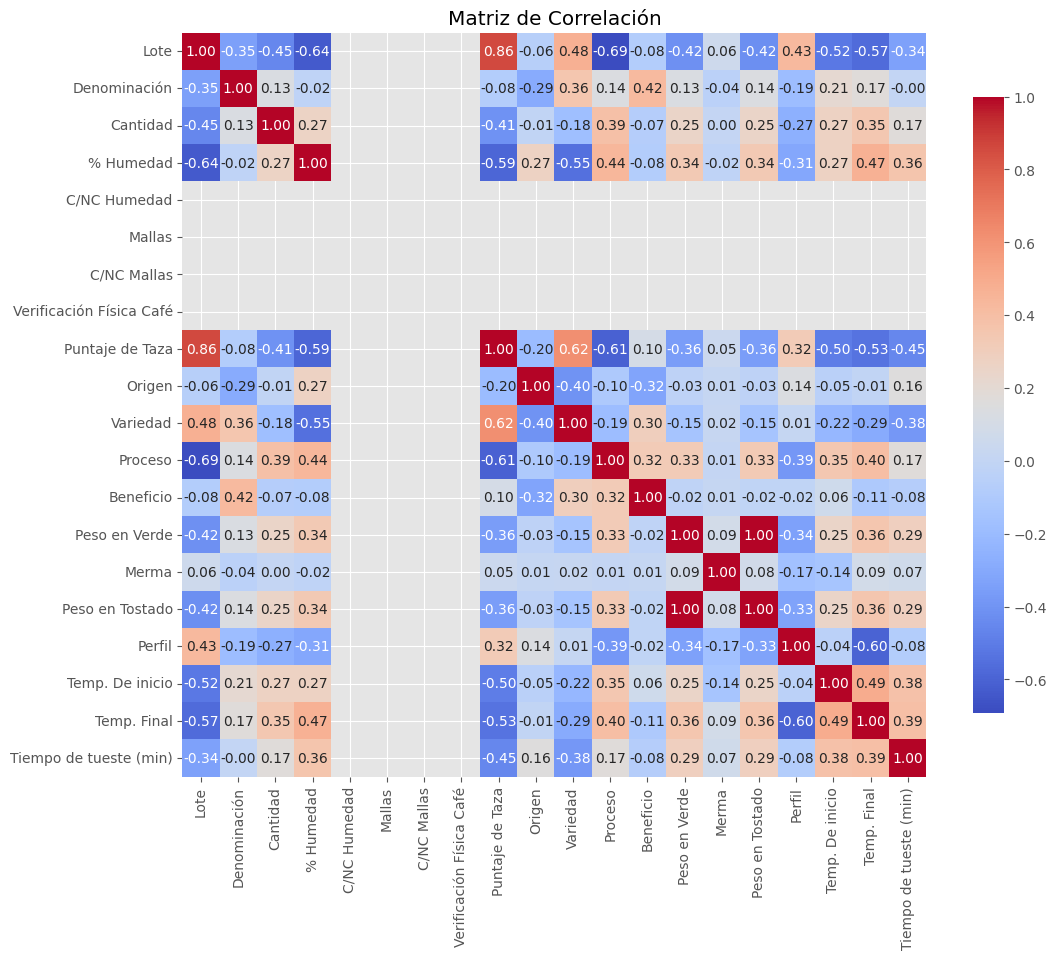

In [355]:
# Correlación entre las variables
correlacion = data_consolidado.corr()
# Visualización de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación')
plt.show()

Como podemos ver en la matriz de correlación, hay algunas variables a las cuales no se puede obtener el valor de la misma, apriori, se debe a que en nuestro dataset la totalidad de los valores en las columnas C/NC y en la Verificación Física Café son iguales, por lo que no nos aportan información relevante para nuestro análisis. Por lo tanto, las eliminaremos de nuestro DataFrame consolidado.

In [356]:
# Eliminar las columnas que no aportan información relevante
data_consolidado = data_consolidado.drop(columns=['C/NC Humedad', 'C/NC Mallas', 'Verificación Física Café'])

Por otro lado, veamos que pasa con la columna mallas

In [357]:
# Distintos valores de la columna "Mallas"
mallas_unicas = data_consolidado['Mallas'].unique()
print("Valores únicos en la columna 'Mallas':", mallas_unicas)
# Eliminar la columna "Mallas" si contiene un único valor
if len(mallas_unicas) == 1:
    data_consolidado = data_consolidado.drop(columns=['Mallas'])

Valores únicos en la columna 'Mallas': [14.]


Como la columna "Mallas" contiene un único valor, podríamos eliminarla del DataFrame, ya que no estaría aportando información relevante para nuestro análisis.

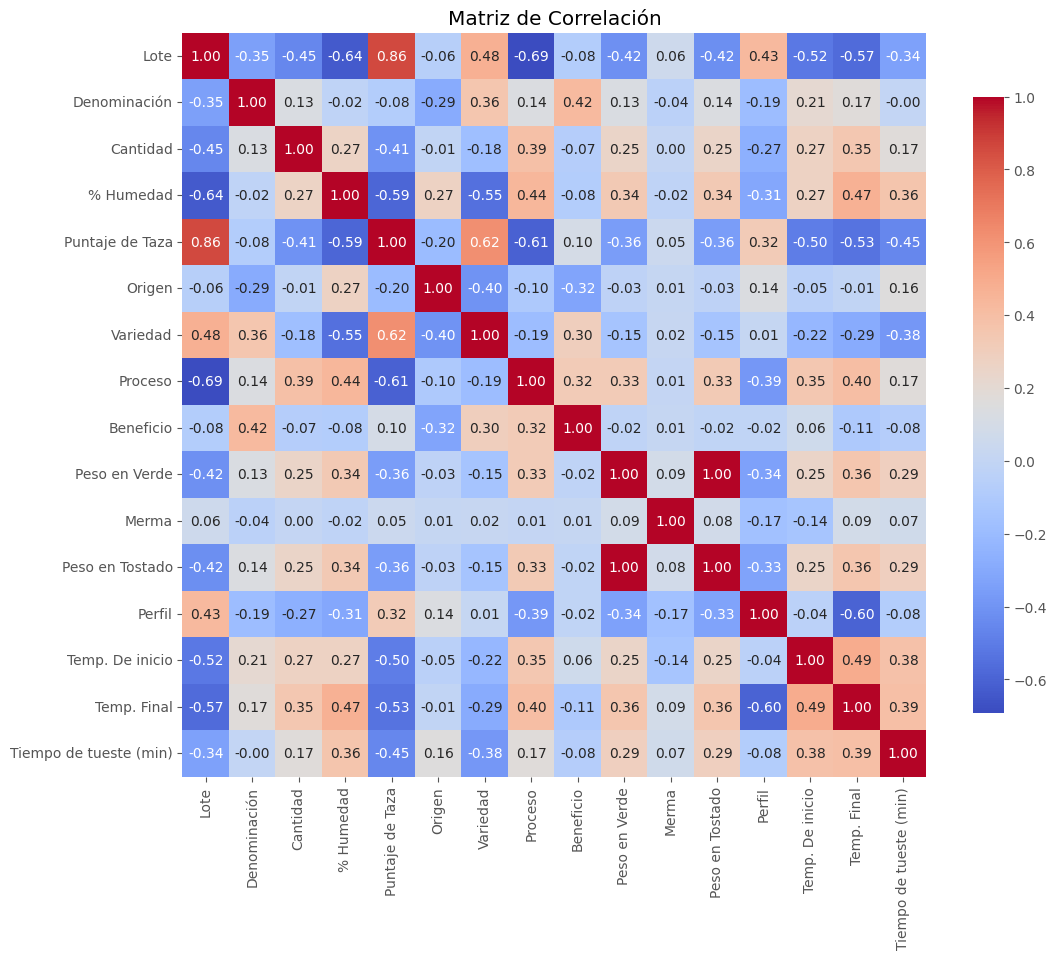

In [358]:
# Correlación entre las variables
correlacion = data_consolidado.corr()
# Visualización de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación')
plt.show()

Hay que recalcar en este punto, que las columnas que recién se acaban de eliminar en este paso, son columnas que para nuestro conjunto de datos no aportan información relevante, sin embargo, al aplicar este mismo modelo a un conjunto de datos, posiblemente más representativo y con más información, estas columnas ya no serían constantes y podrían ser incluidas en el análisis. Por lo tanto, es importante tener en cuenta que este análisis es específico para este conjunto de datos y que puede variar en otros conjuntos de datos.

Como nuestra variable objetivo es el Puntaje de Taza, revisando la matriz de correlación, podemos ver que esta está en su gran mayoría determinada por el Lote a la cual se hace referencia, esto puede ser debido a algún desbalanceo en los datos, o a que el Puntaje de Taza es una variable que depende en gran medida del lote de café, lo que puede ser normal en este tipo de análisis.

In [359]:
correlations = data_consolidado.corr()['Puntaje de Taza'].abs().sort_values(ascending=False)
variables_seleccionadas = correlations[correlations > 0.1].index.tolist()
# Imprimir las variables seleccionadas
print("Variables seleccionadas basadas en la correlación con 'Puntaje de Taza':")
for variable in variables_seleccionadas:
    print(variable)

Variables seleccionadas basadas en la correlación con 'Puntaje de Taza':
Puntaje de Taza
Lote
Variedad
Proceso
% Humedad
Temp. Final
Temp. De inicio
Tiempo de tueste (min)
Cantidad
Peso en Tostado
Peso en Verde
Perfil
Origen


Esta lista nos permite tener una idea inicial de las variables que más influyen en el Puntaje de Taza.

## Entrenamiento de modelos de regresión

El primer paso, será definir las variables de entrada (X) y la variable objetivo (Y) de nuestro modelo de regresión. Para esto, vamos a utilizar las columnas que hemos definido como relevantes para el análisis, y vamos a tomar el Puntaje de Taza como nuestra variable objetivo.

In [ ]:
# Definir las variables de entrada (X) y la variable objetivo (Y)
X = data_consolidado.drop(columns=['Puntaje de Taza'])
Y = data_consolidado['Puntaje de Taza']
grupos = data_consolidado['Lote']  # Usamos 'Lote' como grupo para GroupKFold

X = X.drop(columns=['Lote'])  # Eliminamos 'Lote' de las variables de entrada ya que es nuestra variable de agrupación

Cabe destacar, que hemos eliminado la columna "Lote" de las variables de entrada, ya que es una variable que resulta más como identificador del lote y podría llegar a representar valores sesgados y de aprendizaje de patrones específicos de cada lote (esto se hace a pesar de notar que dejarla resulta en mejores resultados, pero que pueden representar fuga de información, al no poder generalizar el modelo a otros lotes de café). Por lo tanto, la eliminamos de las variables de entrada.

El paso que sigue es hacer la división de los datos en conjuntos de entrenamiento y prueba. En este paso, vamos a usar un tratamiento especial, vamos a usar `GroupKFold` para tener un buen manejo de los lotes, y así evitar que los datos de un mismo lote estén en ambos conjuntos, lo que podría afectar el rendimiento del modelo. Esto nos permitirá tener una mejor generalización del modelo y evitar el sobreajuste. Usaremos un parámetro de 5 para el número de grupos, lo que nos permitirá tener un buen balance entre el tamaño del conjunto de entrenamiento y el conjunto de prueba.

Los modelos a entrenar serán los siguientes:

- **Regresión Lineal**: Un modelo simple que nos permitirá entender la relación lineal entre las variables de entrada y la variable objetivo.
- **Regresión Ridge**: Un modelo de regresión lineal con regularización L2, que nos permitirá evitar el sobreajuste y mejorar la generalización del modelo.
- **Random Forest Regressor**: Un modelo de regresión basado en árboles de decisión, que nos permitirá capturar relaciones no lineales entre las variables de entrada y la variable objetivo.
- **XGBoost Regressor**: Un modelo de regresión basado en árboles de decisión, que nos permitirá capturar relaciones no lineales entre las variables de entrada y la variable objetivo, pero con un enfoque más avanzado y optimizado.

### Aproximación mediante División Clásica de los Datos

En esta primer parte, vamos a utilizar la división clásica de los datos, es decir, vamos a dividir los datos en un conjunto de entrenamiento y un conjunto de prueba, utilizando un 80% de los datos para el entrenamiento y un 20% para la prueba. Con esta división, vamos a entrenar nuestros modelos de regresión y evaluar su rendimiento en el conjunto de prueba.
Cabe notar, que esto es en principio una aproximación inicial, y que será errónea, ya que no estamos teniendo en cuenta la estructura de los lotes, lo que puede afectar el rendimiento del modelo, pues resultará en una fuga de información al poder tener un mismo lote en ambos conjuntos. Sin embargo, es un buen punto de partida para entender el comportamiento de los datos y el rendimiento de los modelos de regresión.

In [ ]:
# Dividimos los datos en conjuntos de entrenamiento y prueba sin mezclar los grupos
X_opc_train, X_opc_test, Y_opc_train, Y_opc_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Regresión Lineal

In [460]:
# Entrenamos un modelo de regresión lineal simple
modelo_regresion_lineal_inicial = LinearRegression()
# Entrenamos el modelo con los datos de entrenamiento
modelo_regresion_lineal_inicial.fit(X_opc_train, Y_opc_train)

y_pred_lin_inicial = modelo_regresion_lineal_inicial.predict(X_opc_test)

# Evaluamos el modelo inicial
mse_lin_inicial = mean_squared_error(Y_opc_test, y_pred_lin_inicial)
print(f"Error Cuadrático Medio (MSE) del modelo de regresión lineal inicial: {mse_lin_inicial:.4f}")
r2_lin_inicial = r2_score(Y_opc_test, y_pred_lin_inicial)
print(f"R^2 del modelo de regresión lineal inicial: {r2_lin_inicial:.4f}")

Error Cuadrático Medio (MSE) del modelo de regresión lineal inicial: 0.4068
R^2 del modelo de regresión lineal inicial: 0.6881


#### Regresión Ridge

In [461]:
# Ridge Regressor
modelo_ridge_inicial = Ridge()
# Entrenamos el modelo con los datos de entrenamiento
modelo_ridge_inicial.fit(X_opc_train, Y_opc_train)
y_pred_ridge_inicial = modelo_ridge_inicial.predict(X_opc_test)
# Evaluamos el modelo inicial
mse_ridge_inicial = mean_squared_error(Y_opc_test, y_pred_ridge_inicial)
print(f"Error Cuadrático Medio (MSE) del modelo Ridge inicial: {mse_ridge_inicial:.4f}")
r2_ridge_inicial = r2_score(Y_opc_test, y_pred_ridge_inicial)
print(f"R^2 del modelo Ridge inicial: {r2_ridge_inicial:.4f}")

Error Cuadrático Medio (MSE) del modelo Ridge inicial: 0.4098
R^2 del modelo Ridge inicial: 0.6858


#### Random Forest Regressor

In [462]:
# Random Forest Regressor
modelo_rf_inicial = RandomForestRegressor(random_state=42)
# Entrenamos el modelo con los datos de entrenamiento
modelo_rf_inicial.fit(X_opc_train, Y_opc_train)
y_pred_rf_inicial = modelo_rf_inicial.predict(X_opc_test)
# Evaluamos el modelo inicial
mse_rf_inicial = mean_squared_error(Y_opc_test, y_pred_rf_inicial)
print(f"Error Cuadrático Medio (MSE) del modelo Random Forest inicial: {mse_rf_inicial:.4f}")
r2_rf_inicial = r2_score(Y_opc_test, y_pred_rf_inicial)
print(f"R^2 del modelo Random Forest inicial: {r2_rf_inicial:.4f}")

Error Cuadrático Medio (MSE) del modelo Random Forest inicial: 0.0016
R^2 del modelo Random Forest inicial: 0.9988


#### XGBoost Regressor

In [463]:
# XGBoost Regressor
modelo_xgb_inicial = XGBRegressor(random_state=42, eval_metric='rmse')
# Entrenamos el modelo con los datos de entrenamiento
modelo_xgb_inicial.fit(X_opc_train, Y_opc_train)
y_pred_xgb_inicial = modelo_xgb_inicial.predict(X_opc_test)
# Evaluamos el modelo inicial
mse_xgb_inicial = mean_squared_error(Y_opc_test, y_pred_xgb_inicial)
print(f"Error Cuadrático Medio (MSE) del modelo XGBoost inicial: {mse_xgb_inicial:.4f}")
r2_xgb_inicial = r2_score(Y_opc_test, y_pred_xgb_inicial)
print(f"R^2 del modelo XGBoost inicial: {r2_xgb_inicial:.4f}")

Error Cuadrático Medio (MSE) del modelo XGBoost inicial: 0.0003
R^2 del modelo XGBoost inicial: 0.9998


Como podemos ver en esta aproximación inicial, los modelos obtienen un rendimiento bastante bueno (en especial Random Forest y XGBoost), y lo hace sin un esfuerzo de parametrización muy grande, lo cual resulta algo extraño. Esto nos podría indicar que hay una fuga de información en los datos, ya que están capturando patrones específicos de los lotes, y esto puede afectar la generalización del modelo a otros lotes de café. Por lo tanto, debemos tener en cuenta que estos resultados pueden no ser representativos de un modelo que se pueda aplicar a otros lotes de café. Es por esto que debemos realizar nuestra segunda aproximación, que será una aproximación más robusta, y que nos permitirá tener un mejor rendimiento del modelo, evitando la fuga de información.

### Aproximación mediante División usando GroupKFold

Ahora sí, tendremos en cuenta la estructura de los lotes, y utilizaremos `GroupKFold` para dividir los datos en conjuntos de entrenamiento y prueba, evitando que los datos de un mismo lote estén en ambos conjuntos. Esto nos permitirá tener una mejor generalización del modelo y evitar el sobreajuste. Utilizaremos un parámetro de 5 para el número de grupos, lo que nos permitirá tener un buen balance entre el tamaño del conjunto de entrenamiento y el conjunto de prueba.

In [386]:
data_consolidado['Lote'].value_counts()

Lote
6     50
0     43
4     36
1     19
23    17
9     17
10    16
8     11
25    11
38    11
7     11
5     10
30     9
17     9
28     9
15     9
19     8
11     8
16     8
3      8
36     7
27     6
14     6
22     6
34     6
37     6
12     6
31     5
26     4
20     4
13     4
35     4
29     3
18     3
21     2
24     1
2      1
Name: count, dtype: int64

Como podemos notar en este caso, la cantidad de filas por lote puede llegar a diferir entre un lote u otro, por lo que el uso del `GroupKFold` podría tener algunos problemas al momento de dividir los datos, ya que algunos lotes pueden tener muy pocos registros, lo que puede afectar el rendimiento del modelo. Es por esto que vamos a filtrar y eliminar los lotes que tengan menos de 5 registros, para evitar problemas al momento de dividir los datos. Siendo así...

In [387]:
conteo_lotes = data_consolidado['Lote'].value_counts()
lotes_validos = conteo_lotes[conteo_lotes >= 4].index
data_filtrado = data_consolidado[data_consolidado['Lote'].isin(lotes_validos)]

Volvamos a realizar la separación de las variables...

In [398]:
X_filtrado = data_filtrado.drop(columns=['Puntaje de Taza'])
Y_filtrado = data_filtrado['Puntaje de Taza']
grupos_filtrado = data_filtrado['Lote']  # Usamos 'Lote' como grupo para GroupKFold
X_filtrado = X_filtrado.drop(columns=['Lote'])  # Eliminamos 'Lote' de las variables de entrada ya que es nuestra variable de agrupación

# Configurar la validación cruzada
gkf = GroupKFold(n_splits=5)

#### Modelo 1: Regresión Lineal

In [436]:
#### Modelo 1: Regresión Lineal
modelo_regresion_lineal = LinearRegression()


# Inicializamos una lista para almacenar los resultados de las métricas
r2_scores_reglin = []
rmse_scores_reglin = []
coefs_por_fold = []

# Realizamos la validación cruzada con GroupKFold
for i, (train_index, test_index) in enumerate(gkf.split(X_filtrado, Y_filtrado, grupos_filtrado)):
    X_train, X_test = X_filtrado.iloc[train_index], X_filtrado.iloc[test_index]
    Y_train, Y_test = Y_filtrado.iloc[train_index], Y_filtrado.iloc[test_index]
    
    # Entrenamos el modelo
    modelo_regresion_lineal.fit(X_train, Y_train)
    
    # Realizamos predicciones
    Y_pred = modelo_regresion_lineal.predict(X_test)
    
    # Calculamos las métricas
    r2 = r2_score(Y_test, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    
    # Almacenamos los resultados
    r2_scores_reglin.append(r2)
    rmse_scores_reglin.append(rmse)

    print(f"Fold {i+1}:")
    print(f"  R² = {r2:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print("-" * 30)

Fold 1:
  R² = 0.0845
  RMSE = 0.8029
------------------------------
Fold 2:
  R² = 0.3062
  RMSE = 1.4002
------------------------------
Fold 3:
  R² = 0.2304
  RMSE = 0.7749
------------------------------
Fold 4:
  R² = 0.0690
  RMSE = 1.7703
------------------------------
Fold 5:
  R² = 0.6748
  RMSE = 0.8535
------------------------------


In [427]:
# Resultados obtenidos
print("Resultados del modelo de Regresión Lineal:")
print(f'R² promedio: {np.mean(r2_scores_reglin):.4f}')
print(f'RMSE promedio: {np.mean(rmse_scores_reglin):.4f}')

Resultados del modelo de Regresión Lineal:
R² promedio: 0.2730
RMSE promedio: 1.1204


Como podemos ver, los resultados con el modelo de regresión lineal son bastante regulares. En principio, hay una variabilidad significativa entre los folds, algunos permitiendonos una buena predicción del Puntaje de Taza, mientras que otros no. Esto puede ser debido a que el modelo de regresión lineal es un modelo simple y no es capaz de capturar relaciones no lineales entre las variables de entrada y la variable objetivo. Continuemos con el siguiente modelo.

#### Modelo 2: Regresión Ridge

In [400]:
# Valores de alpha a probar
alpha_values = [0.01, 0.1, 1.0, 10.0, 100.0, 200.0]

# Recorrer cada alpha
for alpha in alpha_values:
    print(f"\n--- Resultados para alpha = {alpha} ---")
    
    r2_scores = []
    rmse_scores = []

    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_filtrado, Y_filtrado, groups=grupos_filtrado), start=1):
        X_train, X_test = X_filtrado.iloc[train_idx], X_filtrado.iloc[test_idx]
        y_train, y_test = Y_filtrado.iloc[train_idx], Y_filtrado.iloc[test_idx]
        
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        r2_scores.append(r2)
        rmse_scores.append(rmse)

        print(f"Fold {fold}:")
        print(f"  R² = {r2:.4f}")
        print(f"  RMSE = {rmse:.4f}")
        print("-" * 30)
    
    # Promedios por alpha
    print(f"Promedio R²: {np.mean(r2_scores):.4f}")
    print(f"Promedio RMSE: {np.mean(rmse_scores):.4f}")


--- Resultados para alpha = 0.01 ---
Fold 1:
  R² = 0.0793
  RMSE = 0.8052
------------------------------
Fold 2:
  R² = 0.3219
  RMSE = 1.3843
------------------------------
Fold 3:
  R² = 0.2274
  RMSE = 0.7764
------------------------------
Fold 4:
  R² = 0.0693
  RMSE = 1.7700
------------------------------
Fold 5:
  R² = 0.6773
  RMSE = 0.8503
------------------------------
Promedio R²: 0.2750
Promedio RMSE: 1.1173

--- Resultados para alpha = 0.1 ---
Fold 1:
  R² = 0.0754
  RMSE = 0.8069
------------------------------
Fold 2:
  R² = 0.3314
  RMSE = 1.3747
------------------------------
Fold 3:
  R² = 0.2245
  RMSE = 0.7779
------------------------------
Fold 4:
  R² = 0.0670
  RMSE = 1.7723
------------------------------
Fold 5:
  R² = 0.6773
  RMSE = 0.8502
------------------------------
Promedio R²: 0.2751
Promedio RMSE: 1.1164

--- Resultados para alpha = 1.0 ---
Fold 1:
  R² = 0.0520
  RMSE = 0.8171
------------------------------
Fold 2:
  R² = 0.3718
  RMSE = 1.3325
-------

En este caso, los resultados son un poco mejores que los del modelo de regresión lineal, pero aún así hay una variabilidad significativa entre los folds. Esto puede ser debido a que el modelo de regresión Ridge es un modelo de regresión lineal con regularización L2, lo que le permite evitar el sobreajuste y mejorar la generalización del modelo. Los mejores resultados se obtienen a medida que aumenta el valor de alpha, lo que indica que la regularización está funcionando correctamente. Ayudan a generalizar mejor el modelo. Sin embargo, aún no es un resultado óptimo, por lo que continuaremos con el siguiente modelo.

#### Modelo 3: Random Forest Regressor

En este modelo, vamos a hacer uso de GridSearchCV para encontrar los mejores hiperparámetros del modelo. Esto nos permitirá optimizar el rendimiento del modelo y obtener mejores resultados. Vamos a utilizar un rango de valores para los hiperparámetros `n_estimators` y `max_depth`, que son los más importantes para el modelo de Random Forest.

In [437]:
# Definir el modelo base
rf_base = RandomForestRegressor(random_state=42)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Métricas personalizadas
scoring = {
    'r2': 'r2',
    'rmse': make_scorer(rmse, greater_is_better=False)
}

# Definir la malla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=gkf.split(X_filtrado, Y_filtrado, grupos_filtrado),
    scoring=scoring,
    refit='r2',  # optimizamos por R²
    return_train_score=True,
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)

# Ejecutar búsqueda
grid_search_rf.fit(X_filtrado, Y_filtrado)

# Mostrar mejor configuración y resultados
print("Mejores hiperparámetros encontrados:")
print(grid_search_rf.best_params_)
print(f"Mejor R² en validación cruzada: {grid_search_rf.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mejor R² en validación cruzada: 0.7242


Una vez ya tenemos los mejores hiperparámetros, vamos a entrenar el modelo con estos valores y evaluar su rendimiento en el conjunto de prueba. Vamos a utilizar las métricas de R2 y RMSE para evaluar el rendimiento del modelo.

In [ ]:
# Usa los mejores hiperparámetros encontrados por GridSearchCV
mejores_params = grid_search_rf.best_params_
modelo_random_forest = RandomForestRegressor(**mejores_params, random_state=42)

# Entrenar el modelo con los mejores hiperparámetros
rmse_scores = []
r2_scores = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_filtrado, Y_filtrado, groups=grupos_filtrado), start=1):
    X_train, X_test = X_filtrado.iloc[train_index], X_filtrado.iloc[test_index]
    Y_train, Y_test = Y_filtrado.iloc[train_index], Y_filtrado.iloc[test_index]

    modelo_random_forest.fit(X_train, Y_train)
    # Realizamos predicciones
    Y_pred = modelo_random_forest.predict(X_test)
    
    # Calculamos las métricas
    r2 = r2_score(Y_test, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    
    # Almacenamos los resultados
    r2_scores.append(r2)
    rmse_scores.append(rmse)

    print(f"Fold {fold}:")
    print(f"  R² = {r2:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print("-" * 30)

# Promedios
print("Promedios:")
print(f"  RMSE promedio = {sum(rmse_scores)/len(rmse_scores):.4f}")
print(f"  R² promedio   = {sum(r2_scores)/len(r2_scores):.4f}")

Fold 1:
  R² = 0.9674
  RMSE = 0.1514
------------------------------
Fold 2:
  R² = 0.4643
  RMSE = 1.2304
------------------------------
Fold 3:
  R² = 0.7515
  RMSE = 0.4404
------------------------------
Fold 4:
  R² = 0.7371
  RMSE = 0.9407
------------------------------
Fold 5:
  R² = 0.7005
  RMSE = 0.8192
------------------------------
Promedios:
  RMSE promedio = 0.7164
  R² promedio   = 0.7242


Este modelo en específico tiene un rendimiento bastante bueno, logrando un buen poder predictivo (R2) y un error de predicción moderado (RMSE). En general, los Folds siguen el mismo comportamiento, (4 de 5) tienen puntajes R2 por encima de 0.7, lo que indica que el modelo es capaz de capturar la relación entre las variables de entrada y la variable objetivo.

#### Modelo 4: XGBoost Regressor

In [419]:
# Inicializamos el modelo
modelo_xgb = XGBRegressor(random_state=42, verbosity=0)

# Inicializamos listas para almacenar métricas
r2_scores_xgb = []
rmse_scores_xgb = []

# Validación cruzada con GroupKFold
for i, (train_index, test_index) in enumerate(gkf.split(X_filtrado, Y_filtrado, grupos_filtrado)):
    X_train, X_test = X_filtrado.iloc[train_index], X_filtrado.iloc[test_index]
    Y_train, Y_test = Y_filtrado.iloc[train_index], Y_filtrado.iloc[test_index]

    # Entrenamos el modelo
    modelo_xgb.fit(X_train, Y_train)

    # Predicciones
    Y_pred = modelo_xgb.predict(X_test)

    # Métricas
    r2 = r2_score(Y_test, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

    # Almacenamos resultados
    r2_scores_xgb.append(r2)
    rmse_scores_xgb.append(rmse)

    print(f"Fold {i+1}:")
    print(f"  R² = {r2:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print("-" * 30)

# Mostrar promedios
print("Promedios:")
print(f"  R² promedio   = {np.mean(r2_scores_xgb):.4f}")
print(f"  RMSE promedio = {np.mean(rmse_scores_xgb):.4f}")

Fold 1:
  R² = 0.6762
  RMSE = 0.4775
------------------------------
Fold 2:
  R² = 0.1273
  RMSE = 1.5705
------------------------------
Fold 3:
  R² = 0.3989
  RMSE = 0.6848
------------------------------
Fold 4:
  R² = 0.5219
  RMSE = 1.2686
------------------------------
Fold 5:
  R² = 0.8655
  RMSE = 0.5489
------------------------------
Promedios:
  R² promedio   = 0.5180
  RMSE promedio = 0.9101


En este caso, los resultados son algo aceptables en cuanto a la varianza promedio, sin embargo, tenemos una alta variabilidad de esta, probablemente por diferencias entre lotes. El promedio RMSE sigue el mismo comportamiento, con una alta variabilidad. Hagamos un ajuste de los hiperparámetros para ver si podemos mejorar el rendimiento del modelo.

In [423]:
# Definir el modelo base
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir los hiperparámetros a probar
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=gkf.split(X_filtrado, Y_filtrado, grupos_filtrado),
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Ejecutar la búsqueda
random_search.fit(X_filtrado, Y_filtrado)

# Mostrar los mejores parámetros
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Guardar el mejor modelo
mejor_xgb = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores hiperparámetros encontrados:
{'colsample_bytree': np.float64(0.9833274095218347), 'learning_rate': np.float64(0.29908599312677586), 'max_depth': 2, 'n_estimators': 165, 'reg_alpha': np.float64(0.2944488920695857), 'reg_lambda': np.float64(0.38509772860192526), 'subsample': np.float64(0.9255683357584285)}


Usando los hiperparámetros obtenidos, vamos a entrenar el modelo con estos valores y evaluar su rendimiento en el conjunto de prueba. Vamos a utilizar las métricas de R2 y RMSE para evaluar el rendimiento del modelo.

In [424]:
# Inicializamos listas para almacenar métricas
r2_scores_xgb_best = []
rmse_scores_xgb_best = []

# Validación fold a fold
for fold, (train_idx, test_idx) in enumerate(gkf.split(X_filtrado, Y_filtrado, grupos_filtrado), 1):
    X_train, X_test = X_filtrado.iloc[train_idx], X_filtrado.iloc[test_idx]
    y_train, y_test = Y_filtrado.iloc[train_idx], Y_filtrado.iloc[test_idx]
    
    # Entrenar el mejor modelo en este fold
    mejor_xgb.fit(X_train, y_train)
    y_pred = mejor_xgb.predict(X_test)
    
    # Evaluar
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    
    print(f"Fold {fold}:")
    print(f"  R² = {r2:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print("-" * 30)

# Promedios
print("Promedios:")
print(f"  R² promedio   = {np.mean(r2_scores):.4f}")
print(f"  RMSE promedio = {np.mean(rmse_scores):.4f}")

Fold 1:
  R² = 0.7515
  RMSE = 0.4183
------------------------------
Fold 2:
  R² = 0.3433
  RMSE = 1.3623
------------------------------
Fold 3:
  R² = 0.9057
  RMSE = 0.2713
------------------------------
Fold 4:
  R² = 0.8652
  RMSE = 0.6737
------------------------------
Fold 5:
  R² = 0.8658
  RMSE = 0.5484
------------------------------
Promedios:
  R² promedio   = 0.7352
  RMSE promedio = 0.6856


Con este modelo, obtenemos un buen desempeño general, logra explicar más del 73% de la varianza promedio en los datos de testeo. Además, el RMSE nos indica un buen ajuste global, a pesar de que no logramos deshacernos de la alta variabilidad entre los folds, esto será debido a la desigualdad de los lotes y la falta de información en algunos de ellos. Sin embargo, es un buen resultado en general.

## Explicabilidad de los modelos

Para no hacer muy tediosa esta sección y tener en cuenta los 4 modelos entrenados, vamos a utilizar los dos modelos que en promedio, mejor se desempeñaron, que son el Random Forest Regressor y el XGBoost Regressor. Tomando estos dos modelos, vamos a utilizar la técnica de explicabilidad SHAP para entender mejor como estos modelos toman decisiones y que variables son las más importantes para la predicción del Puntaje de Taza. En primer lugar, entrenemos el modelo de Random Forest Regressor y luego el de XGBoost Regressor con todos los datos, para así poder utilizar la técnica de explicabilidad SHAP.

#### Modelo Random Forest Regressor

In [438]:
# Usa los mejores hiperparámetros encontrados por GridSearchCV
mejores_params = grid_search_rf.best_params_
modelo_final_random_forest = RandomForestRegressor(**mejores_params, random_state=42)

# Entrenar el modelo con los mejores hiperparámetros
modelo_final_random_forest.fit(X_filtrado, Y_filtrado)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)

In [467]:
explainer_rf = shap.Explainer(modelo_final_random_forest, X_filtrado)
shap_values_rf = explainer_rf(X_filtrado)

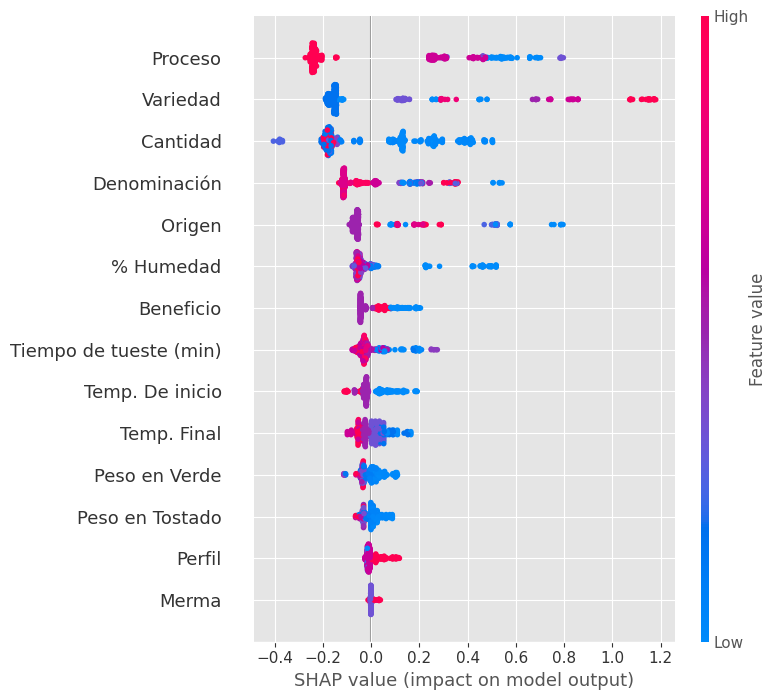

In [468]:
shap.summary_plot(shap_values_rf, X_filtrado)

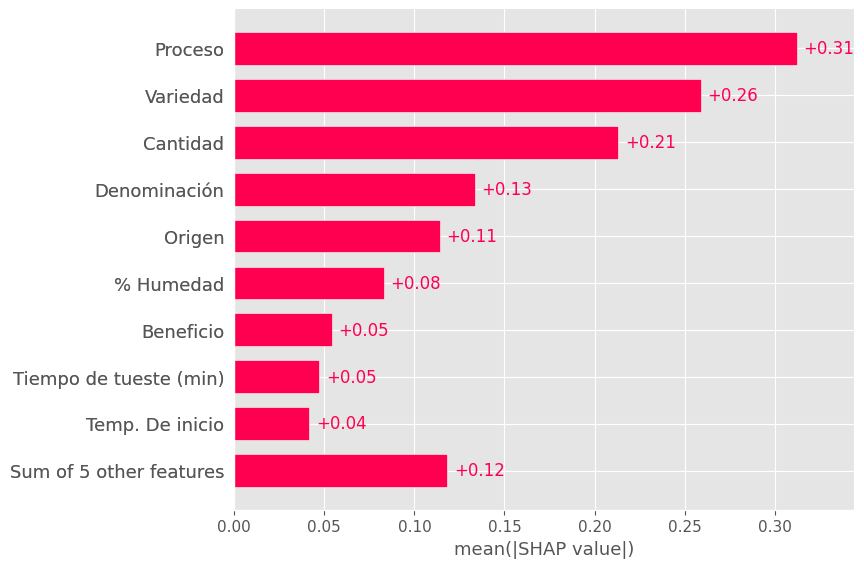

In [469]:
shap.plots.bar(shap_values_rf)

Estos dos gráficos nos permiten ver la importancia de cada variable en la predicción del Puntaje de Taza. En el gráfico de barras, podemos ver que las variables más importantes son "Proceso", "Variedad" y "Cantidad", aunque digamos que las variables en general tienen un impacto un poco en crecimiento y bastante repartido.

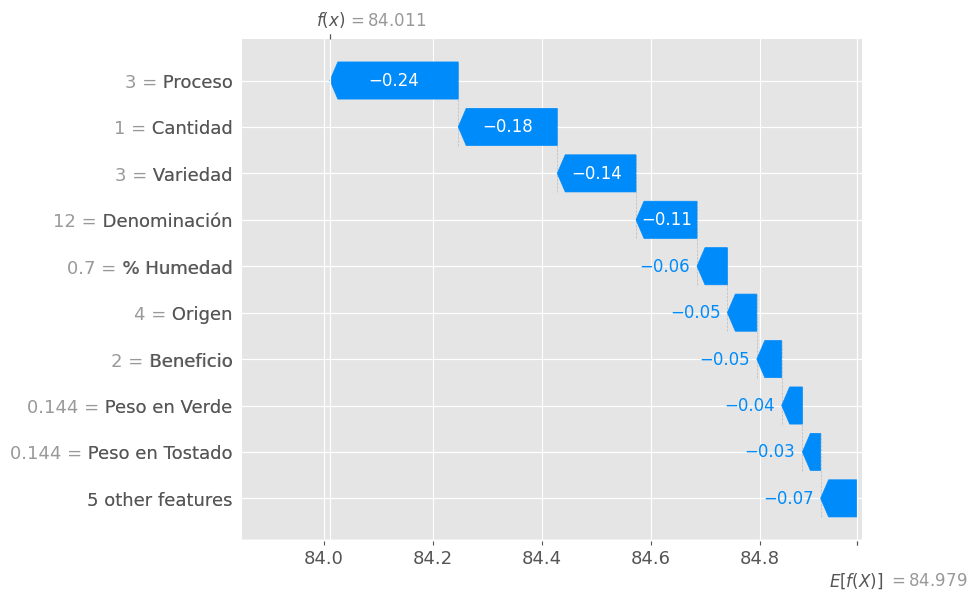

In [470]:
# Escoge una fila, por ejemplo la 10
shap.plots.waterfall(shap_values_rf[10])

En este caso vemos como, a partir del resultado del modelo base (su esperanza), cada característica influye en la predicción para obtener el Puntaje de Taza final, el cual es de 84.011, que resulta bastante aproximado al Puntaje de Taza real del lote, que es de 84.0. Esto nos permite ver como el modelo toma decisiones y que variables son las más importantes para la predicción del Puntaje de Taza. De aquí, podríamos ver que se ve bastante influenciado por el Proceso, la Variedad, Cantidad, lo que nos permite entender mejor como el modelo toma decisiones y que variables son las más importantes para la predicción del Puntaje de Taza.

Usemos ahora el análisis de esta con Feature Importance.

In [443]:
caracteristicas_imp = X_filtrado.columns

# Obtener las importancias de las características
importancias_rf = modelo_final_random_forest.feature_importances_

# Crear un DataFrame para las importancias
importancias_rf = pd.DataFrame({
    'Característica': caracteristicas_imp,
    'Importancia': importancias_rf
}).sort_values(by='Importancia', ascending=False)

In [444]:
display(importancias_rf)

,Característica,Importancia
4,Variedad,0.201990
5,Proceso,0.172769
1,Cantidad,0.132114
3,Origen,0.116753
0,Denominación,0.105512
2,% Humedad,0.069810
13,Tiempo de tueste (min),0.046463
11,Temp. De inicio,0.041502
12,Temp. Final,0.032889
6,Beneficio,0.027176


Como podemos ver, este nos da una mirada un poco distinta de las variables más importantes, pues en este caso, las variables más importantes son la variedad y el proceso. Podríamos pensar que esto es debido a lo que mencionabamos, a pesar de que los pesos impactan más en el resultado final, se contrarrestan entre sí, y por lo tanto, tiene sentido que la variedad y el proceso sean las variables más importantes, ya que son las que determinan la calidad del café en sí. Sin embargo, esto no quiere decir que los pesos no sean importantes, sino que su importancia es relativa a las otras variables.

#### Modelo XGBoost Regressor

In [449]:
# Como el modelo ya esta guardado en el mejor modelo, podemos usarlo directamente

mejor_xgb.fit(X_filtrado, Y_filtrado)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.9833274095218347), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None,
             learning_rate=np.float64(0.29908599312677586), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=165, n_jobs=None,
             num_parallel_tree=None, ...)

In [450]:
explainer_xgb = shap.Explainer(mejor_xgb, X_filtrado)
shap_values_xgb = explainer_xgb(X_filtrado)

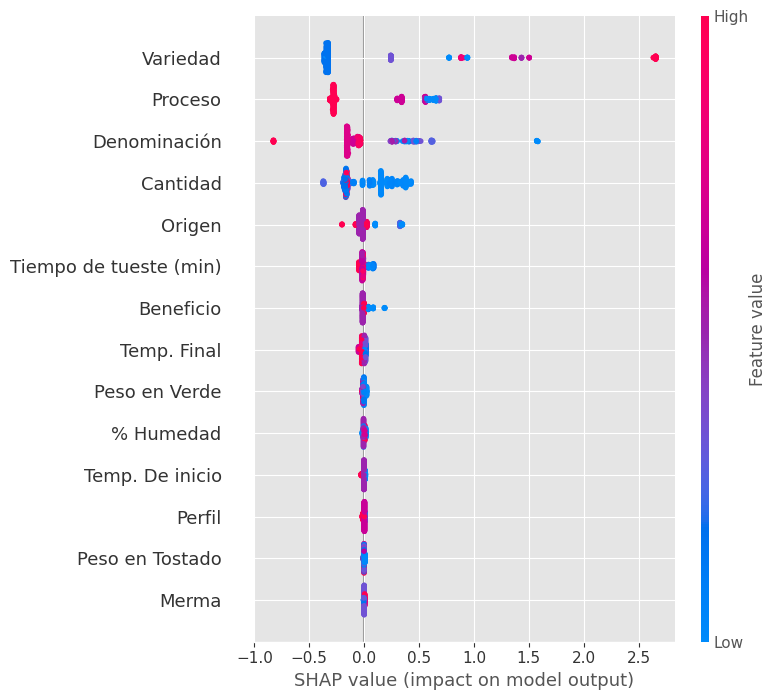

In [451]:
shap.summary_plot(shap_values_xgb, X_filtrado)

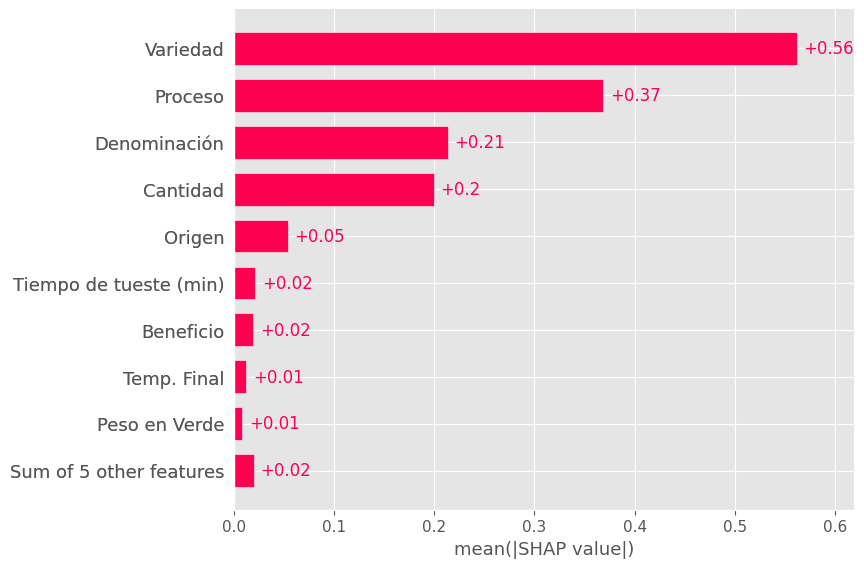

In [453]:
shap.plots.bar(shap_values_xgb)

En este modelo, podemos ver como resulta detectando algo mejor la importancia de las variables, pues en este caso, las variables más importantes son la variedad y el proceso, lo que nos permite entender mejor como el modelo toma decisiones y que variables son las más importantes para la predicción del Puntaje de Taza. Veamoslo para un caso específico, el de un lote en particular.

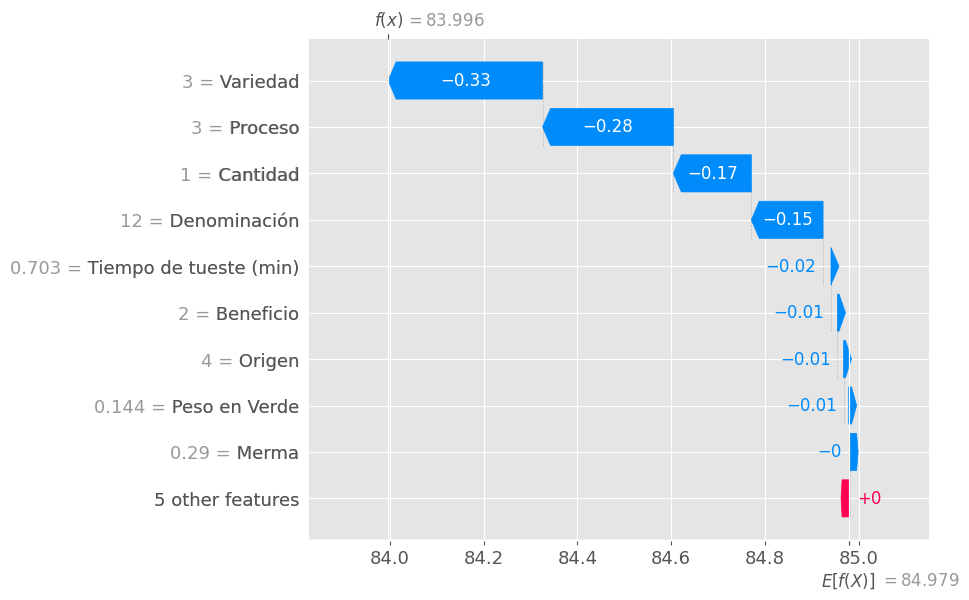

In [455]:
# Escoge una fila, por ejemplo la 10
shap.plots.waterfall(shap_values_xgb[10])

En este caso particular, podemos ver como directamente el modelo no hace cambios bruscos y usa sus variables de mayor importancia para hacer una predicción más directa a nuestro Puntaje de Taza real, que es de 84.0. Nuestro modelo obtiene un puntaje de 83.996, a partir de un valor inicial de 84.979.

In [456]:
caracteristicas_imp = X_filtrado.columns

# Obtener las importancias de las características
importancias_xg = mejor_xgb.feature_importances_

# Crear un DataFrame para las importancias
importancias_xg = pd.DataFrame({
    'Característica': caracteristicas_imp,
    'Importancia': importancias_xg
}).sort_values(by='Importancia', ascending=False)

In [457]:
display(importancias_xg)

,Característica,Importancia
4,Variedad,0.517479
5,Proceso,0.385383
3,Origen,0.054617
0,Denominación,0.020983
1,Cantidad,0.016950
13,Tiempo de tueste (min),0.001320
6,Beneficio,0.001056
9,Peso en Tostado,0.000546
11,Temp. De inicio,0.000532
7,Peso en Verde,0.000526


## Reporte de resultados

Como reporte de resultados, podemos decir que hemos logrado entrenar dos modelos de regresión que nos permiten predecir el Puntaje de Taza del café, utilizando las variables relevantes que hemos identificado en el análisis exploratorio de los datos. Entre los modelos entrenados, el Random Forest Regressor y el XGBoost Regressor son los que mejor se desempeñaron, logrando explicar más del 73% de la varianza promedio en los datos de testeo, con un RMSE aceptable. Además de esto, hemos utilizado la técnica de explicabilidad SHAP para entender mejor como estos modelos toman decisiones y que variables son las más importantes para la predicción del Puntaje de Taza. Entre estos dos modelos, podemos decir que el XGBoost Regressor es el que mejor se desempeñó, logrando una mejor explicación de la varianza y un RMSE más bajo en general, aunque su diferencia no es mucha. Sin embargo, con ayuda de las técnicas de explicabilidad, hemos logrado notar que este segundo modelo es más robusto, menos sensible a los cambios en los datos y capaz de reconocer de mejor manera que variables son las más importantes e influyentes en la predicción del Puntaje de Taza, permitiendo un impacto más grande por parte de las variables más relevantes, como la Variedad y el Proceso, que son las que determinan la calidad del café en sí.

Sin embargo, hay que tener en cuenta que los resultados pueden variar dependiendo del conjunto de datos utilizado, y es que hay que destacar que el conjunto de datos utilizado tiene bastantes inconsistencias y posibles errores en la interpretación de los datos, lo que puede afectar el rendimiento de los modelos. Temas como, sobre que proceso de tostión se realizó la catación, o si el Puntaje de Taza es el mismo para todos los registros de tostión del mismo lote, son temas que pueden afectar el rendimiento de los modelos y que deben ser considerados al momento de interpretar los resultados, pues pueden llevar a conclusiones erróneas si no se tienen en cuenta. Al tratar de tenerlos en cuenta, y evitar definir un modelo que estuviera propenso a la fuga de información, se decidió asumir que el Puntaje de Taza es el mismo para todos los registros de tostión del mismo lote, lo que nos llevo a penalizar los resultados del modelo, con respecto a otros tipos de desarrollo que nos permitirían resultados de casi exactitud, aunque muy propensos tambien al aprendizaje de patrones específicos de cada lote, lo que no es deseable en un modelo que se espera generalice a otros lotes de café. Además de esto, se consideran conjuntos bastante desbalanceados en la cantidad de registros por lote, lo que de cierta manera impacta el promedio de los resultados, al hacer los agrupamientos en Folds.